In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

from keras import metrics

/home/derek/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/derek/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/derek/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/derek/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

I split the data into roughly 60% train, 10% test, and 30% validation fractions in my local directories.

In [2]:
train_path = 'Data/crops_small_train'
test_path = 'Data/crops_small_test'
validation_path = 'Data/crops_small_validation'

In [3]:
train_batches = ImageDataGenerator().flow_from_directory(directory=train_path, 
                                                       target_size=(224, 224), 
                                                       classes=['broadleaf', 'grass',
                                                               'soil', 'soybean'],
                                                       class_mode= 'categorical',
                                                       batch_size=20)

test_batches = ImageDataGenerator().flow_from_directory(directory=test_path, 
                                                       target_size=(224, 224), 
                                                       classes=['broadleaf', 'grass',
                                                               'soil', 'soybean'],
                                                       class_mode= 'categorical',
                                                       batch_size=20)

validation_batches = ImageDataGenerator().flow_from_directory(directory=validation_path, 
                                                       target_size=(224, 224), 
                                                       classes=['broadleaf', 'grass',
                                                               'soil', 'soybean'],
                                                       class_mode= 'categorical',
                                                       batch_size=20)

Found 400 images belonging to 4 classes.
Found 64 images belonging to 4 classes.
Found 192 images belonging to 4 classes.


In [9]:
# Stolen from a GitHub repo at 'https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py'

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [15]:
imgs, labels = next(train_batches)

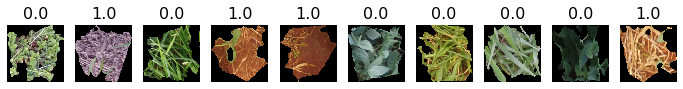

In [16]:
# For a quick test to see if the classes are assigned appropriately, I will plot labels for soil

plots(imgs[:10], titles=labels[:,2])

It would appear that the images have been loaded and classified appropriately!

# Modeling

#### Model 1, Simple CNN

In [30]:
model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        Flatten(),
        Dense(4, activation='softmax')
    ])

Because we are dealing with a balanced classfication problem, accuracy will be our best metric.

In [31]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.fit_generator(train_batches, steps_per_epoch=20,
                   validation_data=validation_batches, validation_steps=10, epochs=10, verbose=2,
                   use_multiprocessing=True)

Epoch 1/10
 - 9s - loss: 322.6208 - accuracy: 0.4900 - val_loss: 205.3754 - val_accuracy: 0.6458
Epoch 2/10
 - 8s - loss: 123.5482 - accuracy: 0.6975 - val_loss: 152.1893 - val_accuracy: 0.6719
Epoch 3/10
 - 9s - loss: 43.8101 - accuracy: 0.8375 - val_loss: 21.2432 - val_accuracy: 0.6562
Epoch 4/10
 - 9s - loss: 14.8943 - accuracy: 0.9150 - val_loss: 149.3622 - val_accuracy: 0.6562
Epoch 5/10
 - 9s - loss: 2.8895 - accuracy: 0.9725 - val_loss: 44.7182 - val_accuracy: 0.7083
Epoch 6/10
 - 8s - loss: 2.0170 - accuracy: 0.9750 - val_loss: 17.9954 - val_accuracy: 0.6979
Epoch 7/10
 - 8s - loss: 1.4412 - accuracy: 0.9875 - val_loss: 235.8201 - val_accuracy: 0.7448
Epoch 8/10
 - 9s - loss: 1.4617 - accuracy: 0.9800 - val_loss: 18.7179 - val_accuracy: 0.7188
Epoch 9/10
 - 9s - loss: 0.3174 - accuracy: 0.9950 - val_loss: 56.9467 - val_accuracy: 0.7344
Epoch 10/10
 - 9s - loss: 0.9062 - accuracy: 0.9875 - val_loss: 62.7296 - val_accuracy: 0.7031


Validation accurcay is continuing to improve but not at a desireable level quite yet. It would appear the model could use more training data. With only 400 samples, it is able to quickly get to perfect accuracy in the training set with only 74% accuracy in the validation set during our best epoch.

#### Model 2,  CNN with dropout layer

In [4]:
model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        Dropout(0.1),
        Flatten(),
        Dense(4, activation='softmax')
    ])

In [5]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
model.fit_generator(train_batches, steps_per_epoch=20,
                   validation_data=validation_batches, validation_steps=10, epochs=10, verbose=2,
                   use_multiprocessing=True)

Epoch 1/10
 - 14s - loss: 351.0138 - accuracy: 0.4900 - val_loss: 61.6949 - val_accuracy: 0.6615
Epoch 2/10
 - 14s - loss: 71.7652 - accuracy: 0.7750 - val_loss: 111.3655 - val_accuracy: 0.6562
Epoch 3/10
 - 13s - loss: 29.4246 - accuracy: 0.8525 - val_loss: 63.8698 - val_accuracy: 0.6510
Epoch 4/10
 - 14s - loss: 20.7988 - accuracy: 0.8800 - val_loss: 210.8009 - val_accuracy: 0.5677
Epoch 5/10
 - 14s - loss: 10.3003 - accuracy: 0.9325 - val_loss: 62.3750 - val_accuracy: 0.7135
Epoch 6/10
 - 14s - loss: 3.4595 - accuracy: 0.9800 - val_loss: 179.4107 - val_accuracy: 0.6771
Epoch 7/10
 - 15s - loss: 2.1656 - accuracy: 0.9825 - val_loss: 3.3835 - val_accuracy: 0.7188
Epoch 8/10
 - 14s - loss: 0.9347 - accuracy: 0.9875 - val_loss: 160.2682 - val_accuracy: 0.6771
Epoch 9/10
 - 14s - loss: 0.4288 - accuracy: 0.9925 - val_loss: 18.8210 - val_accuracy: 0.6979
Epoch 10/10
 - 14s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 69.3492 - val_accuracy: 0.7344


#### Model 3, CNN with MaxPooling layer

In [9]:
model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        MaxPooling2D(pool_size=(3,3)),
        Dropout(0.1),
        Flatten(),
        Dense(4, activation='softmax')
    ])

In [10]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.fit_generator(train_batches, steps_per_epoch=20,
                   validation_data=validation_batches, validation_steps=10, epochs=10, verbose=2,
                   use_multiprocessing=True)

Epoch 1/10
 - 8s - loss: 113.7854 - accuracy: 0.4175 - val_loss: 33.6532 - val_accuracy: 0.5625
Epoch 2/10
 - 8s - loss: 24.5834 - accuracy: 0.6925 - val_loss: 18.3448 - val_accuracy: 0.6615
Epoch 3/10
 - 8s - loss: 8.5597 - accuracy: 0.8050 - val_loss: 1.4056 - val_accuracy: 0.7188
Epoch 4/10
 - 8s - loss: 6.1245 - accuracy: 0.8475 - val_loss: 10.3492 - val_accuracy: 0.7240
Epoch 5/10
 - 8s - loss: 6.7369 - accuracy: 0.8575 - val_loss: 37.7106 - val_accuracy: 0.7344
Epoch 6/10
 - 8s - loss: 3.1145 - accuracy: 0.9075 - val_loss: 13.4561 - val_accuracy: 0.7135
Epoch 7/10
 - 8s - loss: 1.2969 - accuracy: 0.9450 - val_loss: 23.8972 - val_accuracy: 0.6823
Epoch 8/10
 - 8s - loss: 1.2403 - accuracy: 0.9500 - val_loss: 10.2267 - val_accuracy: 0.7135
Epoch 9/10
 - 10s - loss: 0.8206 - accuracy: 0.9625 - val_loss: 32.5504 - val_accuracy: 0.7031
Epoch 10/10
 - 12s - loss: 1.5564 - accuracy: 0.9725 - val_loss: 4.3638 - val_accuracy: 0.7604


#### Model 4, VGG16 

In [12]:
vgg16 = keras.applications.vgg16.VGG16()

In [5]:
# Create new sequential model based on vgg16, ignoring the dense output layer

model = Sequential()

for layer in vgg16.layers[:-1]:
    model.add(layer)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
# set remaining layers to not-trainable, add dense layer with 4 outputs

for layer in model.layers:
    layer.trainable = False

In [8]:
model.add(Dense(4, activation='softmax'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.fit_generator(train_batches, steps_per_epoch=20,
                   validation_data=validation_batches, validation_steps=10, epochs=5, verbose=2,
                   use_multiprocessing=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
 - 151s - loss: 1.4250 - acc: 0.3675 - val_loss: 1.0530 - val_acc: 0.5208
Epoch 2/5
 - 151s - loss: 0.8324 - acc: 0.6575 - val_loss: 0.6601 - val_acc: 0.7552
Epoch 3/5
 - 151s - loss: 0.5475 - acc: 0.8025 - val_loss: 0.4748 - val_acc: 0.8438
Epoch 4/5
 - 151s - loss: 0.3990 - acc: 0.8850 - val_loss: 0.3795 - val_acc: 0.8854
Epoch 5/5
 - 151s - loss: 0.3166 - acc: 0.9200 - val_loss: 0.3232 - val_acc: 0.9167


#### Model 5, VGG16 with more training epochs

In [16]:
# Save model, then run through some more epochs

model.save('models/vgg16_crops.h5')

In [4]:
model = load_model('models/vgg16_crops.h5')








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
model.fit_generator(train_batches, steps_per_epoch=20,
                   validation_data=validation_batches, validation_steps=10, epochs=5, verbose=2,
                   use_multiprocessing=True)

Epoch 1/5
 - 152s - loss: 0.2638 - acc: 0.9350 - val_loss: 0.2868 - val_acc: 0.9323
Epoch 2/5
 - 155s - loss: 0.2246 - acc: 0.9525 - val_loss: 0.2594 - val_acc: 0.9323
Epoch 3/5
 - 156s - loss: 0.1945 - acc: 0.9650 - val_loss: 0.2392 - val_acc: 0.9427
Epoch 4/5
 - 156s - loss: 0.1731 - acc: 0.9675 - val_loss: 0.2261 - val_acc: 0.9427
Epoch 5/5
 - 156s - loss: 0.1547 - acc: 0.9700 - val_loss: 0.2113 - val_acc: 0.9531


In [6]:
model.save('models/vgg16_crops.h5')

In [93]:
scores = model.evaluate_generator(test_batches, steps=4)

In [97]:
print(f'Test set accurcay = {scores[1]:.2f}%')

Test set accurcay = 0.94%


The model is performing much better than our previous models. More epochs would likely continue to improve the model performance. Training the model over a greater amount of data would likely lead to improved performance as well.